# EDA Madrid Central

Importamos las librerias que vamos a utilizar más adelante.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
%matplotlib inline
import matplotlib.pyplot as plt

Importamos los datasets sobre la calidad del aire de los años 2011 a 2021 desde **[el portal de datos del ayuntamiento de madrid](https://datos.madrid.es/sites/v/index.jsp?vgnextoid=aecb88a7e2b73410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD)**

In [2]:
datos_2011 = pd.read_csv(r".\datos - copia\datos11.csv", sep=";")
datos_2012 = pd.read_csv(r".\datos - copia\datos12.csv", sep=";")
datos_2013 = pd.read_csv(r".\datos - copia\datos13.csv", sep=";")
datos_2014 = pd.read_csv(r".\datos - copia\datos14.csv", sep=";")
datos_2015 = pd.read_csv(r".\datos - copia\datos15.csv", sep=";")
datos_2016 = pd.read_csv(r".\datos - copia\datos201612.csv", sep=";")
datos_2017 = pd.read_csv(r".\datos - copia\datos17.csv", sep=";")
datos_2018 = pd.read_csv(r".\datos - copia\datos201812.csv", sep=";")
datos_2019 = pd.read_csv(r".\datos - copia\datos201912.csv", sep=";")
datos_2020 = pd.read_csv(r".\datos - copia\datos202012.csv", sep=";")
datos_2021 = pd.read_csv(r".\datos - copia\datos202105.csv", sep=";")

### FUNCIONES DE LIMPIEZA DE DATOS
Vamos a crear funciones para limpiar los datasets.

In [3]:
def cleaning_valid(df):    
    """
    Las columnas con V validan los dato de las columnas D que les corresponden. Por ejemplo, V01 va a validar la columna D01 y V02 la de D02, etc... El valor V corresponde a un dato valido y N a un dato no valido.
    La funcion itera sobre esas columnas y cuando se encuentra con un dato que no es valido, asigna el valor None a la columna del día que le corresponde.
    
    Despues de la iteracion, se procederá a eliminar las columnas de validacion.
    """
    
    #Checkeamos los datos verificados y reemplazamos los N por None
    for i in range(0, len(df.index)):
        for j in range(4, len(df.columns)):
            if df.iloc[i, j] == 'N':
                df.iloc[i, (j - 1)] = None
                
    #Eliminamos las columnas de validaciones (V01, V02..V31)
    for i in df.columns:
        if i.startswith("V"):
            df.drop(i, axis=1, inplace=True)
            
    return df

In [4]:
def columns_remove(df):
    """
    Quitamos las columnas PROVINCIA, MUNICIPIO y PUNTO_MUESTRE que no nos interesan para nuestra analasis.
    """
    df.drop(["PROVINCIA","MUNICIPIO","PUNTO_MUESTREO"], axis=1, inplace=True)
    
    return df

In [5]:
def adding_columns(df):
    """
    Vamos a crear nuevas columnas con datos que necesitamos para llevar a cabo nuestra analisis:
        - una columna con la fecha en modo datetime para fijar luego esa columna como index,
        - una columna con la temporada del año,
        - una columna con las medias mensuales de contaminacion.
        
    """
    #crear una columna Date (a partir de la columnas con el año y el mes).
    df["Date"] = pd.to_datetime(df.ANO.astype(str) + '/' + df.MES.astype(str))
    
    #añadimos una columna con la estacion del año.
    season = []

    for i in df["MES"]:
        if 3<= i <=5 :
            season.append("Spring")
    
        elif 6<= i <= 8:
            season.append("Summer")

        elif 9<= i <= 11:
            season.append("Autumn")

        else:
            season.append("Winter")
        
    df["Season"] = season
    
    #creamos una columna con las medias mensuales. 
    Mean = []

    for i in range(0, len(df.index)):
    
        Mean.append(df.iloc[i, 4:35].mean())
    
    df["Mean per month(ug/m3)"] = Mean
    
    return df

In [6]:
def rename_col(df):
    """
    Procedemos a cambiar los nombre de algunas columnas y cambiar el nombre de algunas variables (el tipo de contaminante, el nombre de las estaciones meteorologicas)
    
    """
    #cambiar el tipo de magnitud por el nombre de su contaminante

    df["MAGNITUD"].replace({8:"NO2"}, inplace=True)
    
    #cambiar el numero de las estaciones por su nombre
    df["ESTACION"].replace({4:"Plz de España", 35:"Plz del Carmen"}, inplace=True)
    
    #renombramos las columnas
    df.rename(columns={"ESTACION":"Station", "MAGNITUD":"Pollutant", "ANO": "Year", "MES":"Month"}, inplace=True)
    
    return df

In [7]:
def col_dia_remove(df):
    """
    Eliminamos las columnas con los dias. Visto que tenemos las medias mensuales, no las vamos a utilizar màs.
    """
    
    df.drop(columns=["D01", "D02", "D03","D04", "D05", "D06", "D07", "D08", "D09", "D10", "D11", "D12", "D13", "D14", "D15", "D16", "D17",
                         "D18", "D19", "D20", "D21", "D22", "D23", "D24", "D25", "D26", "D27", "D28", "D29", "D30", "D31"], inplace=True)
    
    return df

In [8]:
def slicing_estacion_magnitud(df):
    
    """
    Hacemos un slicing para quedarnos con el tipo de contaminante y las estaciones que nos interesan.
    """
    #slicing para quedarnos con el contaminante NO2
    df = df[df['Pollutant'] == "NO2"]
    
    #slicing para quedarnos con las 2 estaciones ubicadas en Madrid Central
    df = df[(df["Station"] == "Plz de España") | (df["Station"] == "Plz del Carmen") ]
    
    return df

In [9]:
def cleaning_data(df):
    """
    esta funcion incluye las 6 funciones que acabamos de crear para la limpieza de los datasets
    """
    
    df = cleaning_valid(df)
    df = columns_remove(df)
    df = adding_columns(df)
    df = rename_col(df)
    df = col_dia_remove(df)
    df = slicing_estacion_magnitud(df)
    
    return df
    

### LIMPIEZA, JOIN Y CREACION DE MASCARAS
Procedemos a limpiar los datasets con las funciones que acabamos de crear:

In [10]:
#Pasamos todos los dataset por la funcion de limpieza
datos_2011= cleaning_data(datos_2011)
datos_2012 = cleaning_data(datos_2012)
datos_2013 = cleaning_data(datos_2013)
datos_2014 = cleaning_data(datos_2014)
datos_2015 = cleaning_data(datos_2015)
datos_2016 = cleaning_data(datos_2016)
datos_2017=cleaning_data(datos_2017)
datos_2018=cleaning_data(datos_2018)
datos_2019= cleaning_data(datos_2019)
datos_2020=cleaning_data(datos_2020)
datos_2021 = cleaning_data(datos_2021)

Vamos a juntar los distintos dataset y fijar la columna Date como index:

In [11]:
#hacemos un concat de todos los datos de los diferentes años
all_data = pd.concat([datos_2011, datos_2012,datos_2013,datos_2014,datos_2015,datos_2016,datos_2017,datos_2018,datos_2019,datos_2020,datos_2021]).sort_values(by="Date").reset_index()

In [12]:
#quitamos la columna index y fijamos la columna Date como el index
all_data = all_data.drop(columns=["index"])
all_data = all_data.set_index('Date')

Creamos las mascaras que utilizaremos más adelante:

In [13]:
mask_espania = all_data["Station"] == "Plz de España"
mask_carmen = all_data["Station"] == "Plz del Carmen"

In [14]:
all_data = all_data.sort_values(["Date","Station"])

### ANALISIS DE LA CONTAMINATION ANTES DE MADRID CENTRAL ( ANTES DE DECIEMBRE 2018)

#### La Organización Mundial de la Salud ha fijado un limite de 40 ug/m3 de media anual a no sobrepasar. Nos servirá de punto de referencia.

#### Grafica de las media mensuales desde enero 2011 hasta noviembre 2018.

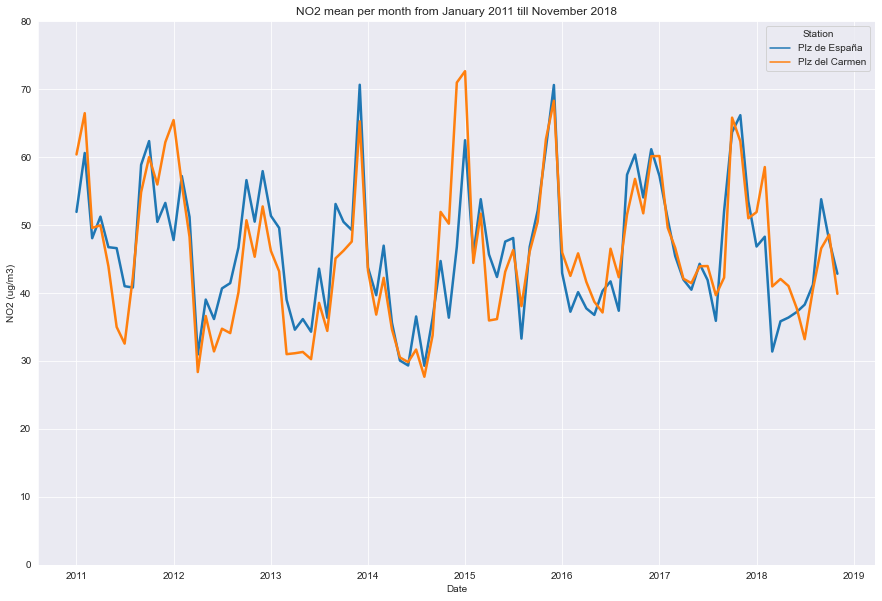

In [36]:
a = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].reset_index()

sns.set_style("darkgrid")
plt.figure(figsize=(15,10))
sns.lineplot(data = a,
            x = 'Date',
            y = "Mean per month(ug/m3)",
            hue = "Station",
            linewidth = 2.5,
            palette ="tab10")
plt.ylim(0,80)
plt.ylabel("NO2 (ug/m3)")
plt.title("NO2 mean per month from January 2011 till November 2018");

#### Medias anuales
(para 2018, no se ha tomado en cuenta el mes de deciembre como ya había Madrid Central)

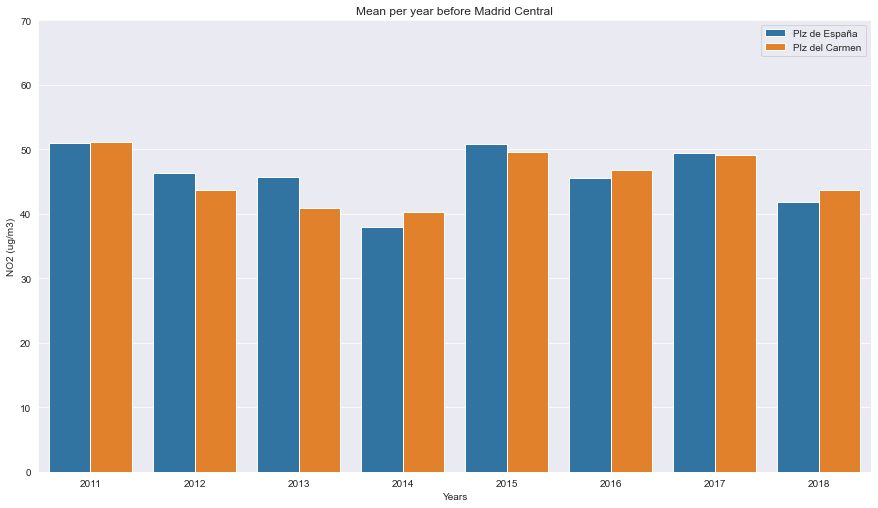

In [49]:
data_before = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"]

sns.set_style("darkgrid")
g = sns.catplot(
    data=data_before, kind="bar",
    x="Year", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None,  palette ="tab10", legend=False)

g.set_axis_labels("Years", "NO2 (ug/m3)")
g.set(title="Mean per year before Madrid Central")
g.set(ylim=(0, 70))
g.fig.set_figwidth(13)
g.fig.set_figheight(7)
plt.legend(loc="upper right");

In [17]:
all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].groupby(["Station", "Year"]).mean().round(2)

Mean per month(ug/m3)
Station        Year                       
Plz de España  2011                  51.00
               2012                  46.35
               2013                  45.70
               2014                  37.95
               2015                  50.80
               2016                  45.60
               2017                  49.46
               2018                  41.80
Plz del Carmen 2011                  51.10
               2012                  43.65
               2013                  40.85
               2014                  40.30
               2015                  49.66
               2016                  46.73
               2017                  49.08
               2018                  43.73

Notamos que hemos cumplido con los 40 ug/m3 solamente en el año 2014 en plaza de España.

#### Grafica de las media mensuales por estacion del año

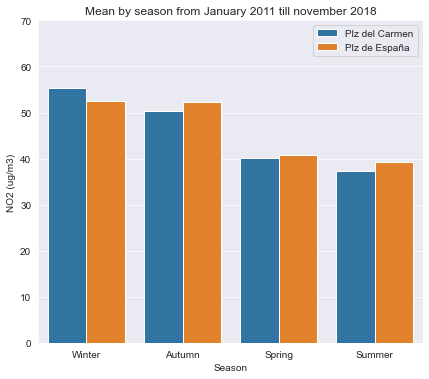

In [37]:
data_estacion = all_data[["Year", "Station","Season", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].sort_values(by="Mean per month(ug/m3)",ascending=False)
g = sns.catplot(
    data=data_estacion, kind="bar",
    x="Season", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None,  palette ="tab10", legend=False)
g.set_axis_labels("Season", "NO2 (ug/m3)")
g.set(title="Mean by season from January 2011 till november 2018");
g.set(ylim=(0, 70))
g.fig.set_figwidth(6)
g.fig.set_figheight(5)
plt.legend(loc="upper right")

#### Visto la gran diferencia de contaminacion entre una temporada y la otra, sacamos las medias segun el mes del año:

In [19]:
all_data[["Month","Station","Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"].groupby(["Station","Month"]).mean().round(2)

Mean per month(ug/m3)
Station        Month                       
Plz de España  1                      50.54
               2                      48.63
               3                      44.50
               4                      39.20
               5                      38.50
               6                      39.47
               7                      41.48
               8                      36.96
               9                      50.63
               10                     54.76
               11                     51.37
               12                     59.13
Plz del Carmen 1                      55.75
               2                      49.70
               3                      44.53
               4                      38.24
               5                      37.47
               6                      36.06
               7                      38.44
               8                      37.39
               9                      45.03
               10                     53.82
               11                     51.95
               12                     61.51

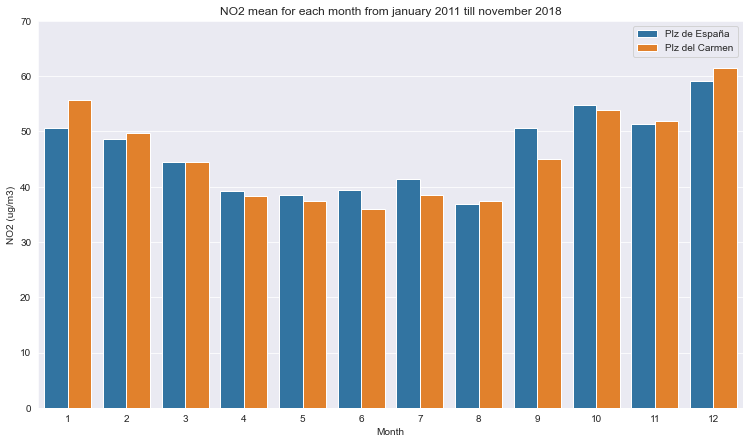

In [48]:
data_before = all_data[["Month", "Station", "Mean per month(ug/m3)"]].loc["2011-01-01":"2018-11-01"]

g = sns.catplot(
    data=data_before, kind="bar",
    x="Month", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None, legend=False)
g.set_axis_labels("Month", "NO2 (ug/m3)")
g.set(title="NO2 mean for each month from january 2011 till november 2018");
g.set(ylim=(0, 70))
g.fig.set_figwidth(11)
g.fig.set_figheight(6)
plt.legend(loc="upper right");

Podemos ver que los meses más contaminantes son Enero, Febrero, marzo, septiembre, octubre, noviembre y diciembre.

## CONTAMINACION DE NO2 DESPUES DE LA IMPLEMENTACION DE MADRID CENTRAL

#### Grafica de las medias mensuales desde diciembre 2018 hasta febrero 2020 (nos paramos antes del estado de alarma debido al corona virus).

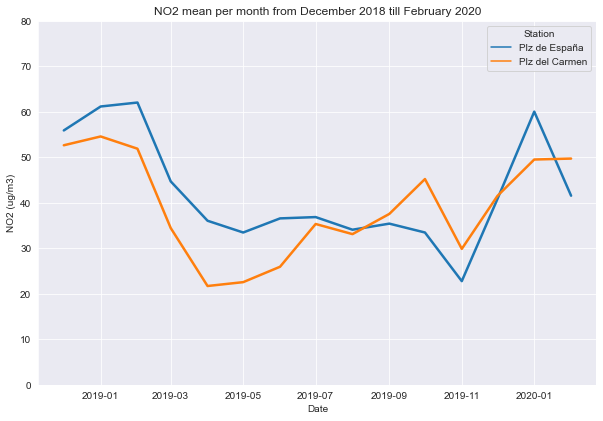

In [39]:
#Sacamos las curvas de las medias mensuales para apreciar la evolucion de ella.
a = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2018-12-01":"2020-02-01"].reset_index()

sns.set_style("darkgrid")
plt.figure(figsize=(10,6.7))
sns.lineplot(data = a,
            x = 'Date',
            y = "Mean per month(ug/m3)",
            hue = "Station",
            linewidth = 2.5
            )
plt.ylim(0,80)
plt.ylabel("NO2 (ug/m3)")
plt.title("NO2 mean per month from December 2018 till February 2020");

#### sacamos las medias segun el mes del año

In [22]:
all_data[["Month","Station","Mean per month(ug/m3)"]].loc["2018-12-01":"2020-02-01"].groupby(["Station","Month"]).mean().round(2)

Mean per month(ug/m3)
Station        Month                       
Plz de España  1                      60.56
               2                      51.77
               3                      44.68
               4                      36.03
               5                      33.45
               6                      36.55
               7                      36.84
               8                      34.06
               9                      35.40
               10                     33.45
               11                     22.77
               12                     48.34
Plz del Carmen 1                      52.02
               2                      50.77
               3                      34.43
               4                      21.70
               5                      22.55
               6                      25.93
               7                      35.32
               8                      33.10
               9                      37.53
               10                     45.19
               11                     29.86
               12                     47.05

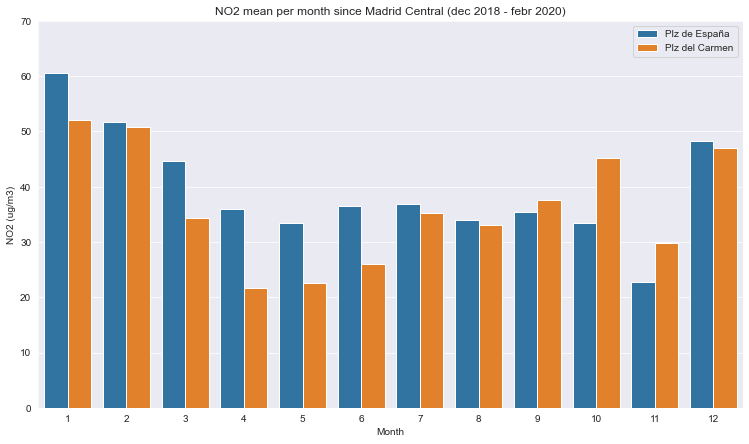

In [42]:
#sacamos una grafica de barra con las medias mensuales. Se puede apreciar una tendencia a la baja en comparacion con la grafica de barra del periodo anterior a Madrid central
data_after = all_data[["Month", "Station", "Mean per month(ug/m3)"]].loc["2018-12-01":"2020-02-01"]
g = sns.catplot(
    data=data_after, kind="bar",
    x="Month", y="Mean per month(ug/m3)", hue="Station", capsize=.2, ci=None, legend=False)
g.set_axis_labels("Month", "NO2 (ug/m3)")
g.set(title="NO2 mean per month since Madrid Central (dec 2018 - febr 2020)");
g.set(ylim=(0, 70))
g.fig.set_figwidth(11)
g.fig.set_figheight(6)
plt.legend(loc="upper right");

#### Comparacion de las medias mensuales de cada mes con el mes correspondiente del año anterior

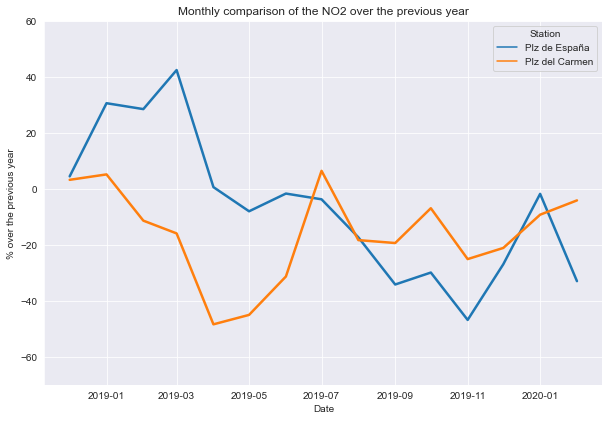

In [45]:
#El "shift" está fijado en 24 porque hay 2 estaciones por mes y así va a ir justo un año atràs.
all_data["Previous year"] = 100 * (all_data["Mean per month(ug/m3)"] - all_data["Mean per month(ug/m3)"].shift(24)) / all_data["Mean per month(ug/m3)"].shift(24)
d = all_data.loc["2018-12-01":"2020-02-01"].reset_index()

sns.set_style("darkgrid")
plt.figure(figsize=(10,6.7))
sns.lineplot(data = d,
            x = 'Date',
            y = "Previous year",
            hue = "Station",
            linewidth = 2.5,
            palette ="tab10")
plt.ylim(-70,60)
plt.ylabel("% over the previous year")
plt.title("Monthly comparison of the NO2 over the previous year");

Se puede apreciar que las curvas se ubican en su mayoria por debajo de 0. Vamos a verlo más en detalle.
Vamos a comparar el primer año de Madrid Central con el año anterior:

In [25]:
#primer año de Madrid Central
round(all_data[["Station","Previous year"]].loc["2018-12-01":"2019-11-01"].groupby("Station").mean())

,Previous year
Station,
Plz de España,-3.0
Plz del Carmen,-17.0


Creamos una función para comparar diferentes periodos con el mismo periodo del año anterior:

In [26]:
def month_to_previous_year(estacion, fecha1, fecha2):
    
    """
    esta función compara los datos de un periodo con el del año anterior.
    
    Tenemos 3 variables: la estacion meteolorigica, la fecha de incio del periodo y la fecha de fin del periodo
    
    """
    if estacion == "Plaza de España":
        
        return round(all_data[mask_espania]["Previous year"].loc[fecha1:fecha2].mean())
    
    if estacion == "Plaza del Carmen":
        return round(all_data[mask_carmen]["Previous year"].loc[fecha1:fecha2].mean())
    

Comparamos las medias durante el periodo de transicion de Madrid Central (diciembre 2018 - marzo 2019) con un año atrás:

In [27]:
#Para plaza españa:
month_to_previous_year("Plaza de España","2018-12-01","2019-03-01")

26

In [28]:
#Para plaza del Carmen:
month_to_previous_year("Plaza del Carmen","2018-12-01","2019-03-01")

-4

 y despues del periodo de transicion hasta llegar al primer año de Madrid central

In [29]:
#Para plaza españa:
month_to_previous_year("Plaza de España","2019-04-01","2019-11-01")

-17

In [30]:
#Para plaza del Carmen:
month_to_previous_year("Plaza del Carmen","2019-04-01","2019-11-01")

-24

Miramos el arranque del segundo año de Madrid Central (entonces en comparación con los primeros meses del periodo de transicion)

In [31]:
#Para plaza españa:
month_to_previous_year("Plaza de España","2019-12-01","2020-02-01")

-23

In [32]:
#Para plaza del Carmen:
month_to_previous_year("Plaza del Carmen","2019-12-01","2020-02-01")

-9

Averiguamos como ha quedado la media de NO2 del año 2019

In [33]:
all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2019-01-01":"2019-12-01"].groupby("Station").mean().round(2)

,Year,Mean per month(ug/m3)
Station,,
Plz de España,2019,39.76
Plz del Carmen,2019,36.12


Podemos ver que las 2 medias están por debajo de los 40 ug/m3.

# CONCLUSION
Los datos de contaminación de NO2 proporcionado por el ayuntamiento de Madrid nos indican que, desde la implementación de Madrid Central, han bajado de forma significativa tanto en plaza del Carmen como en plaza de España después de haber pasado el periodo de transición.

Tantas las medias mensuales como la comparación de cada mes con el mismo mes del año anterior corroboran esa bajada. 


### BONUS TRACK - Que ha pasado despues del estado de alarma (a partir de julio 2020)?

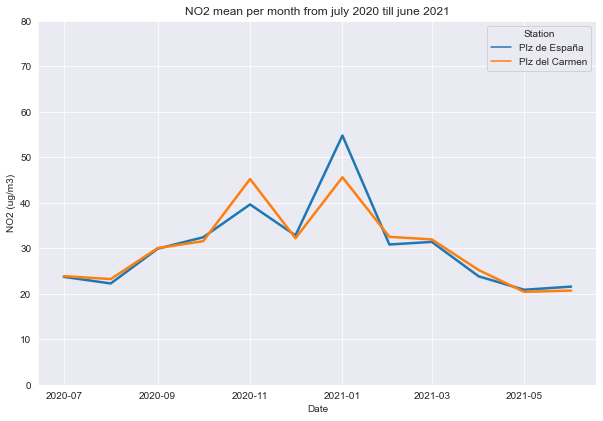

In [46]:
z = all_data[["Year", "Station", "Mean per month(ug/m3)"]].loc["2020-07-01":"2021-06-01"].reset_index()

sns.set_style("darkgrid")
plt.figure(figsize=(10,6.7))
sns.lineplot(data = z,
            x = 'Date',
            y = "Mean per month(ug/m3)",
            hue = "Station",
            linewidth = 2.5
            )
plt.ylim(0,80)
plt.ylabel("NO2 (ug/m3)")
plt.title("NO2 mean per month from july 2020 till june 2021");

Podemos notar que estamos frente a una contaminación de N02 con bajos historicos. Ese ultimo grafico esta puesto unicamente de forma informativa. Visto la crisis del Corona virus y su impacto en nuestros habitos, no sacaremos ninguna conclusion al respeto de la influencia de Madrid Central en estos datos.